In [99]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import geemap
import ee


In [100]:
ee.Authenticate()


Successfully saved authorization token.


In [101]:
ee.Initialize()

In [102]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [103]:
import folium

In [104]:
# Use Sentinel-2 data.
BANDS = ['NDVI', 'WDRVI', 'SAVI']
def add_indexes(img): 
    ndvi = img.expression(
        '(nir - red) / (nir  + red + a)', {
            'a': 1e-5,
            'nir': img.select('B8'),
            'red': img.select('B4')
        }
       
    ).rename('NDVI')

    wdrvi = img.expression(
        '(a * nir - red) / (a * nir + red)', {
            'a': 0.2,
            'nir': img.select('B8'),
            'red': img.select('B4')
        }
    ).rename('WDRVI')

    savi = img.expression(
        '1.5 * (nir - red) / (nir + red + 0.5)', {
            'nir': img.select('B8'),
            'red': img.select('B4')
        }
    ).rename('SAVI')

    return ee.Image.cat([ndvi, wdrvi, savi])

image = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate('2018-01-01', '2018-04-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(add_indexes) \
    .median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': BANDS, 'min': -1, 'max': 1})
map = folium.Map(location=[              
              9.835828,
              0.162381,
])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map.add_child(folium.LayerControl())
map


In [105]:
geometry = ee.Geometry.Polygon([
    [
         
[-0.7940895801090364,11.42834230661449],
 
[-0.7502730136417513,11.42834230661449],
 
[-0.7502730136417513,11.450551478009817],
 
[-0.7940895801090364,11.450551478009817],

[-0.7940895801090364,11.42834230661449],
        
        
        
        
     ]])

In [106]:
Start_period = ee.Date('2019-03-01')
End_period = ee.Date('2020-03-15')

In [107]:
Baseline2019 = ee.ImageCollection('COPERNICUS/S2_SR').filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',10)).filter(ee.Filter.eq('SPACECRAFT_NAME', 'Sentinel-2B')).filter(ee.Filter.eq('SENSING_ORBIT_DIRECTION', 'DESCENDING')).filterBounds(geometry).filterDate('2019-03-01', '2020-03-15')
 
Baseline2019Median = Baseline2019.median()

visParams = { 
    'min': 0,
    'max': 0.0002,
    'palette': '000000'
    }
# This set of code will use the geemap package to display the map within your Colab
# environment, of the rates of atmospheric NO2 in 2019
Mapa = geemap.Map()
Mapa.addLayer(Baseline2019Median)

Mapa.setCenter(9.835828,
              0.162381)
Mapa

Map(center=[0.162381, 9.835828], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [108]:
s2Collection =  ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',10)).filter(ee.Filter.eq('SPACECRAFT_NAME', 'Sentinel-2B')).filter(ee.Filter.eq('SENSING_ORBIT_DIRECTION', 'DESCENDING')).filterBounds(geometry).filterDate(Start_period,End_period).map(add_indexes)
#print('first S2 Collection :',s2Collection);
#print('total number of images found :',s2Collection.size());
image = s2Collection
# This set of code will use the geemap package to display the map within your Colab
mapid = image.getMapId({'bands': BANDS, 'min': -1, 'max': 1})
map = folium.Map(location=[              
              9.835828,
              0.162381,
])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

In [109]:
#print('first S2 Collection :',s2Collection)
#print('total number of images found :',s2Collection.size())

In [110]:
mndvi = s2Collection.select('NDVI','EVI','SAVI','NDWI')
#print('Monthly NDVI stack :',mndvi)


In [111]:
opt_bands = mndvi.toList(ee.Number(mndvi.size()))
#print("list of bands",opt_bands)

In [112]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.median(),
                                  scale=1113.2,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  """

  def reduce_region_function(img):
    """
      Function returns
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [113]:
#print(geometry)

In [114]:
# Create a feature with a masked geometry
feature = ee.Feature(geometry)

# Unmask the feature's geometry
unmasked_geometry = feature.geometry()

# Print the unmasked geometry
print(unmasked_geometry.getInfo())



{'type': 'Polygon', 'coordinates': [[[-0.7940895801090364, 11.42834230661449], [-0.7502730136417513, 11.42834230661449], [-0.7502730136417513, 11.450551478009817], [-0.7940895801090364, 11.450551478009817], [-0.7940895801090364, 11.42834230661449]]]}


In [115]:
roi = unmasked_geometry

In [116]:
import os

In [117]:
out_dir = os.path.join(os.path.expanduser(''), '')
filename = os.path.join(out_dir, 'data-collection-python.tif')

In [118]:
images = ee.Image.clip(image,roi).unmask()
bucket = geemap.ee_export_image_collection(s2Collection,out_dir="/Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs", scale=90, region=None)


Total number of images: 16

Exporting 1/16: 20190303T102019_20190303T103501_T30PYT.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs/20190303T102019_20190303T103501_T30PYT.tif


Exporting 2/16: 20190313T102019_20190313T102552_T30PYT.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs/20190313T102019_20190313T102552_T30PYT.tif


Exporting 3/16: 20190621T102029_20190621T103026_T30PYT.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs/20190621T102029_20190621T103026_T30PYT.tif


Exporting 4/16: 20190701T102029_20190701T103132_T30PYT.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs/20190701T102029_20190701T103132_T30PYT.tif


Exporting 5/16: 20190929T102029_20190929

In [120]:
import os 
import pickle 
import shutil 

filepath = "/Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs"

#filenames = ["20200127T102209_20200127T103047_T30PYT.tif", "20190701T102029_20190701T103132_T30PYT.tif", "20190303T102019_20190303T103501_T30PYT.tif", "20200216T102019_20200216T102936_T30PYT.tif", "20190929T102029_20190929T103731_T30PYT.tif", "20200107T102319_20200107T103621_T30PYT.tif", "20200206T102109_20200206T103321_T30PYT.tif", "20190313T102019_20190313T102552_T30PYT.tif", "20191128T102259_20191128T103402_T30PYT.tif", "20191218T102339_20191218T102604_T30PYT.tif", "20200307T101759_20200307T102902_T30PYT.tif", "20191108T102139_20191108T103655_T30PYT.tif", "20200226T101909_20200226T103701_T30PYT.tif", "20190621T102029_20190621T103026_T30PYT.tif", "20191228T102339_20191228T103241_T30PYT.tif", "20191118T102219_20191118T103143_T30PYT.tif"]
filenames = os.listdir(filepath)


for file in filenames:
    if file.endswith("tif"):
        dst_file = file[:4] + "-" + file[4:6] + "-" + file[6:8] + ".tif"
        print(dst_file)
        shutil.copyfile(os.path.join(filepath, file), os.path.join(filepath, dst_file))

2020-01-27.tif
2019-07-01.tif
2019-03-03.tif
2020-02-16.tif
2019-09-29.tif
2020-01-07.tif
2020-02-06.tif
2019-03-13.tif
2019-11-28.tif
2019-12-18.tif
2020-03-07.tif
2019-11-08.tif
2020-02-26.tif
2019-06-21.tif
2019-12-28.tif
2019-11-18.tif


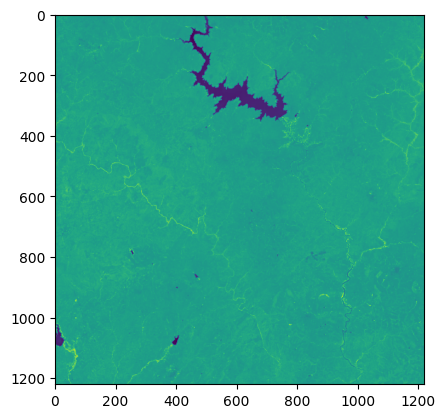

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.17430923 0.19051239 0.18438041 ... 0.1731569  0.18478464 0.        ]
 [0.17871182 0.17751298 0.18095829 ... 0.17666185 0.18762367 0.        ]
 ...
 [0.17903477 0.19169657 0.18924674 ... 0.14483224 0.14628457 0.        ]
 [0.17152104 0.19130195 0.18074324 ... 0.14351775 0.16339193 0.        ]
 [0.17807407 0.18488043 0.1817711  ... 0.15993595 0.1909987  0.        ]]


In [121]:
import rasterio
from rasterio.plot import show

with rasterio.open('/Users/aaronl/Documents/GitHub/cracow-poland-rural-farmers/reports/outputs/2019-03-03.tif') as src:
    all_bands = src.read()
    # Select the band you want to show
    band1 = all_bands[0]
    show(band1)
    print(band1)